In [11]:
#! pip install pydot-ng
#! pip install graphviz


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


     -------------------------------------- 47.1/47.1 kB 585.5 kB/s eta 0:00:00



[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [37]:
import os 
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt

import cv2
from PIL import Image

from tqdm.notebook import tqdm
import time

tqdm.pandas()

plt.rcParams["font.family"] = "Times New Roman"
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)


os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
#tf.config.threading.set_intra_op_parallelism_threads(num_threads=10)

In [2]:
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
df = pd.read_csv('train_2_0.csv')
df2 = df.drop(df.columns[1:-2],axis=1)
df2

,Id,Pawpularity,path
0,0007de18844b0dbbb5e1f607da0606e0,63,data/train/0007de18844b0dbbb5e1f607da0606e0.jpg
1,0009c66b9439883ba2750fb825e1d7db,42,data/train/0009c66b9439883ba2750fb825e1d7db.jpg
2,0013fd999caf9a3efe1352ca1b0d937e,28,data/train/0013fd999caf9a3efe1352ca1b0d937e.jpg
3,0018df346ac9c1d8413cfcc888ca8246,15,data/train/0018df346ac9c1d8413cfcc888ca8246.jpg
4,001dc955e10590d3ca4673f034feeef2,72,data/train/001dc955e10590d3ca4673f034feeef2.jpg
...,...,...,...
9851,ffbfa0383c34dc513c95560d6e1fdb57,15,data/train/ffbfa0383c34dc513c95560d6e1fdb57.jpg
9852,ffcc8532d76436fc79e50eb2e5238e45,70,data/train/ffcc8532d76436fc79e50eb2e5238e45.jpg
9853,ffdf2e8673a1da6fb80342fa3b119a20,20,data/train/ffdf2e8673a1da6fb80342fa3b119a20.jpg
9854,fff19e2ce11718548fa1c5d039a5192a,20,data/train/fff19e2ce11718548fa1c5d039a5192a.jpg


In [4]:
#переводит изображение в тензор
# path - путь к изображению
# img_w - выходная ширина изображения
# img_h - выходная высота изображения
def prep_image(path, img_w, img_h):
    orig_img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(orig_img, channels=3)
    img = tf.cast(img, dtype=tf.float32) / 255.0
    img = tf.image.resize(img, (img_w, img_h))
    return img

(720, 405, 3)


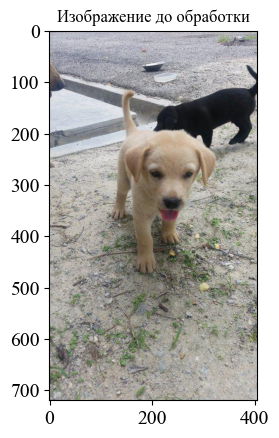

In [33]:
example_image = plt.imread(df2['path'][0])
plt.title('Изображение до обработки')
plt.imshow(example_image)
print(example_image.shape)

(128, 128, 3)


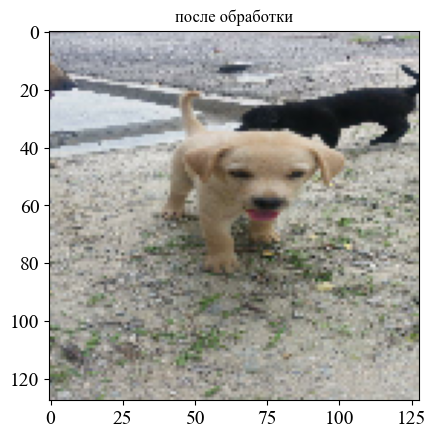

In [6]:
prep_example_img = prep_image(df2['path'][0], 128,128)
plt.title('после обработки')
plt.imshow(prep_example_img)
print(prep_example_img.shape)

In [ ]:
paths = df2.path
X = np.array([prep_image(p, 128, 128) for p in paths])
print(X.shape)

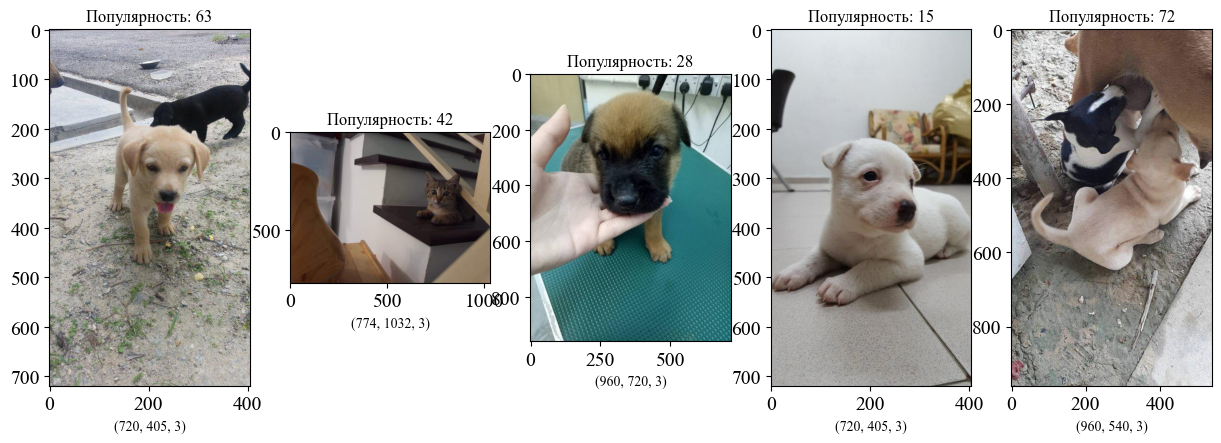

In [34]:
fig,ax = plt.subplots(1,5, figsize=(15,15))
for i in range(5):
    img=plt.imread(df.path[i])
    ax[i].imshow(img)
    ax[i].set_title(f"Популярность: {df.Pawpularity[i]}")
    ax[i].set_xlabel(img.shape)
plt.savefig('Photo before preprocessing')

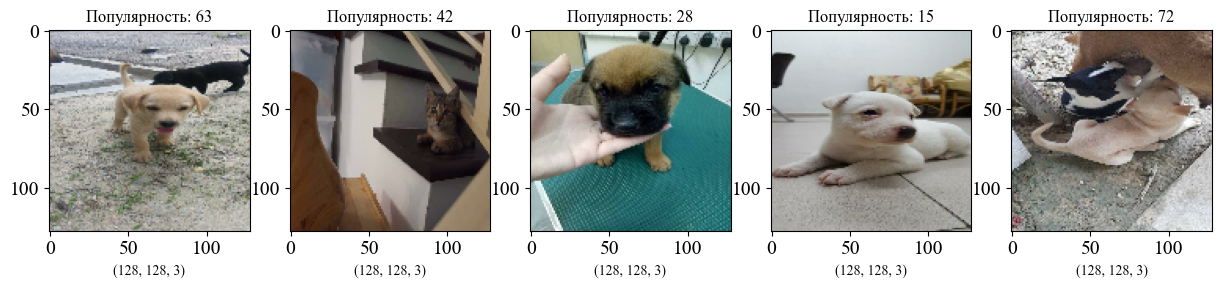

In [35]:
fig,ax = plt.subplots(1,5, figsize=(15,15))
for i in range(5):
    ax[i].imshow(X[i])
    ax[i].set_title(f"Популярность: {df.Pawpularity[i]}")
    ax[i].set_xlabel(X[i].shape)
plt.savefig('photo after preprocessing')

In [9]:
#np.save(file='X', arr=X)
#with tf.device("CPU"):
X = np.load('X.npy')
Y = df2.Pawpularity / 100


In [11]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0) 

In [12]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


(8870, 128, 128, 3)
(8870,)
(986, 128, 128, 3)
(986,)


In [13]:
from keras import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, InputLayer
from keras.utils.vis_utils import plot_model

## Первая модель

In [14]:
model11 = Sequential(layers=[
    InputLayer(input_shape=(X_train.shape[1],X_train.shape[2], X_train.shape[3])),
    Conv2D(32, (4,4), padding='same',activation='relu'),
    MaxPooling2D(padding='same'),
    Conv2D(64, (4,4), padding='same',activation='relu'),
    # MaxPooling2D(padding='same'),
    # Conv2D(128, (2,2), padding='same',activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(1)
],
name='cnn.1'
)

In [15]:
model11.summary()

Model: "cnn.1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        32832     
                                                                 
 flatten (Flatten)           (None, 262144)            0         
                                                                 
 dense (Dense)               (None, 128)               33554560  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                             

In [50]:
plot_model(model11, to_file='model11.png')

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [17]:
model11.compile(optimizer='adam', loss=keras.losses.mean_squared_error, metrics=[keras.metrics.mean_absolute_error, 
                                                                                keras.metrics.RootMeanSquaredError(),
                                                                                ])

In [18]:
#with tf.devices('CPU'):
history1 = model11.fit(
                         X_train,
                         Y_train,
                         epochs=25,
                         verbose=1,
                         validation_split=0.2,
                         batch_size=16,
                         )

Epoch 1/25
444/444 [==============================] - 167s 374ms/step - loss: 3.9477 - mean_absolute_error: 0.2900 - root_mean_squared_error: 1.9869 - val_loss: 0.0464 - val_mean_absolute_error: 0.1542 - val_root_mean_squared_error: 0.2155
Epoch 2/25
444/444 [==============================] - 163s 367ms/step - loss: 0.0437 - mean_absolute_error: 0.1561 - root_mean_squared_error: 0.2091 - val_loss: 0.0469 - val_mean_absolute_error: 0.1559 - val_root_mean_squared_error: 0.2165
Epoch 3/25
444/444 [==============================] - 161s 362ms/step - loss: 0.0351 - mean_absolute_error: 0.1392 - root_mean_squared_error: 0.1873 - val_loss: 0.0489 - val_mean_absolute_error: 0.1587 - val_root_mean_squared_error: 0.2212
Epoch 4/25
444/444 [==============================] - 160s 361ms/step - loss: 0.0277 - mean_absolute_error: 0.1240 - root_mean_squared_error: 0.1665 - val_loss: 0.0518 - val_mean_absolute_error: 0.1698 - val_root_mean_squared_error: 0.2276
Epoch 5/25
444/444 [====================

In [19]:
model11.evaluate(X_train, Y_train)
model11.evaluate(X_test, Y_test)

31/31 [==============================] - 2s 74ms/step - loss: 0.0491 - mean_absolute_error: 0.1660 - root_mean_squared_error: 0.2217


[0.04914521425962448, 0.16597819328308105, 0.2216871976852417]

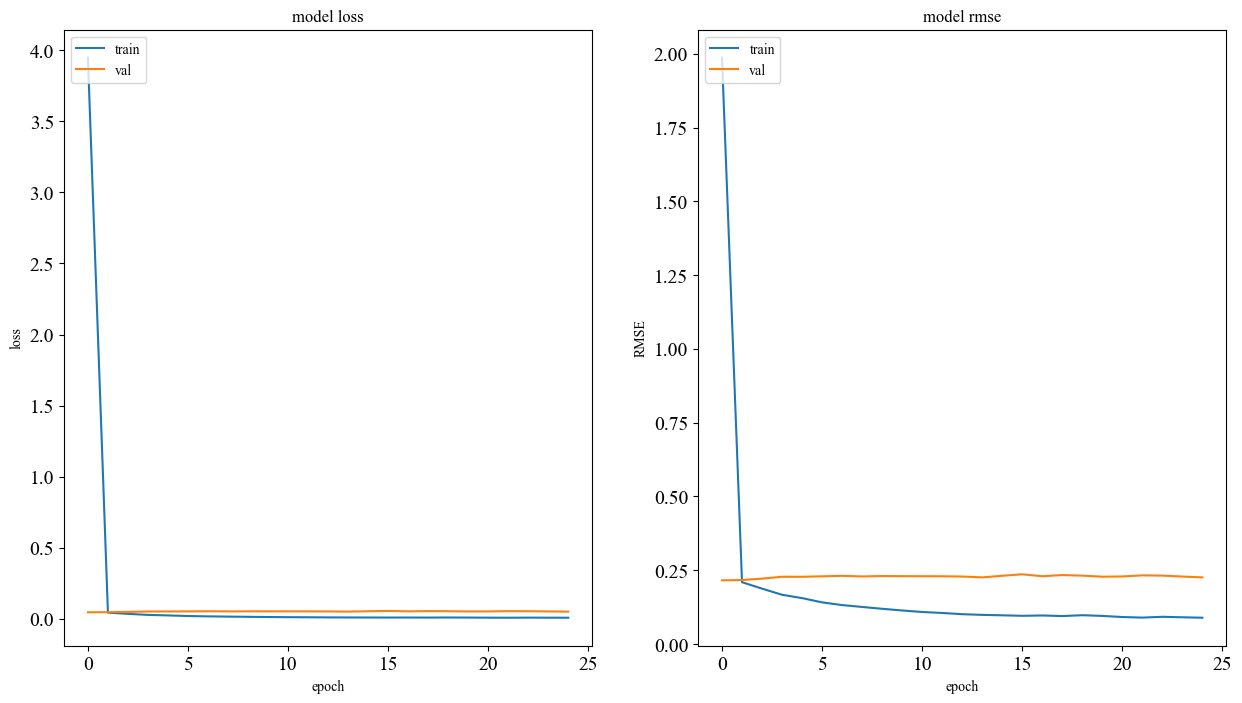

In [44]:
# summarize history for loss
fig, ax = plt.subplots(1,2, figsize=(15,8))

ax[0].plot(history1.history['loss'])
ax[0].plot(history1.history['val_loss'])
ax[0].set_title('model loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'], loc='upper left')

ax[1].plot(history1.history['root_mean_squared_error'])
ax[1].plot(history1.history['val_root_mean_squared_error'])
ax[1].set_title('model rmse')
ax[1].set_ylabel('RMSE')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')
plt.savefig('model11_metrics.png')
plt.show()


In [24]:
pred1=model11.predict(X_test)

31/31 [==============================] - 2s 72ms/step


In [26]:
#pred1

In [27]:
df_res = pd.DataFrame(data=Y_test)
df_res['model1_pred'] = pred1

In [28]:
df_res

,Pawpularity,model1_pred
8094,0.03,0.426962
9764,0.26,0.410168
9090,0.22,0.312573
9075,0.03,0.475941
4807,0.28,0.296374
...,...,...
9200,0.25,0.253440
8269,0.27,0.600944
2119,0.24,0.342884
6071,0.41,0.401338


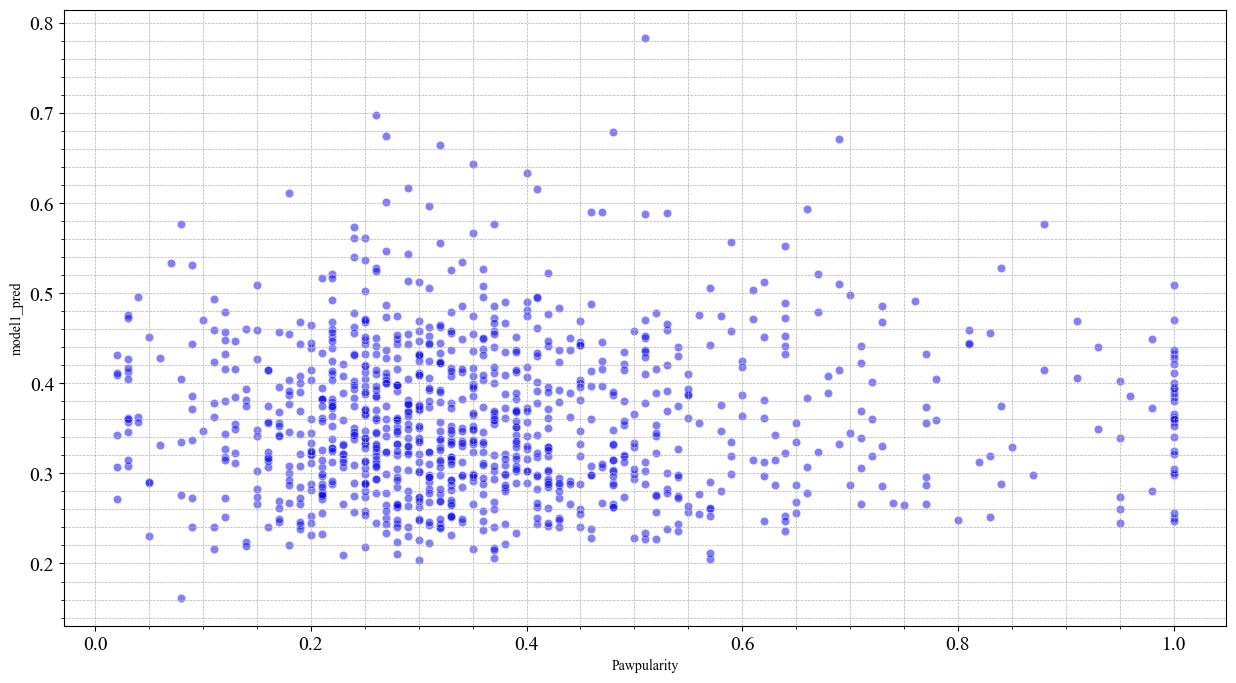

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator

plt.figure(figsize=(15,8))
ax = sns.scatterplot(data=df_res, x='Pawpularity', y='model1_pred', markers=True, alpha=0.5, color='blue')

# Установка минорных делений на оси X и Y
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())

# Добавление сетки
plt.grid(which='both', linestyle='--', linewidth=0.5)

# Сохранение графика
plt.savefig('scatter_with_grid_model1.png')

In [49]:
model11.save('model11')

INFO:tensorflow:Assets written to: model11\assets


INFO:tensorflow:Assets written to: model11\assets


## Вторая модель

In [ ]:
model2 = Sequential(
    
)